## Постановка задачи

### Описание данных
- Имеются данные акселерометра (a_x, a_y, a_z) и гироскопа (g_x, g_y, g_z) с частотой 10 Hz, с размеченными периодами приемов пищи (target). 
- Два человека в течение примерно 3 недель принимали пищу и размечали временные промежутки (соответственно, разметка является бинарной), в течение которых они кушали.

### Задачи
- Исследовать данные (exploratory data analysis).
- Обучить модель, которая будет предсказывать промежутки приемов пищи.
- Посчитать метрики Precision, Recall, F1 для полученной модели (можно считать поточечно, можно сами события приемов).

### Цель тестирования
- Познакомить вас с нашими данными и возможными задачами/проектами.
- Проверить навыки написания кода и навыки формирования решения для поставленной задачи.
- Самое главное провести небольшое исследование по данной задаче и сформировать базовую модель.

Классическая [статья](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5839104/pdf/nihms728790.pdf) по данной задаче. Кроме этого, можно почитать любую статье по Human Activity Recognition. Если вам интересен Deep Learning, то можно почитать следующую [статью](https://mug.ee.auth.gr/wp-content/uploads/kyritsis2019detecting.pdf).

P.S. Мы не будем смотреть на качество полученной модели, мы посмотрим на умение проводить анализ с данными и ваш код.

Удачи!

## Import packages and data

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from utils import DataLoader

### Loading data

In [2]:
data_dir = 'data_compressed'
loader = DataLoader(data_dir)

print('Number of files: {0}'.format(len(loader)))

Number of files: 47


### Indexing

In [3]:
# indexing
sample = loader[0]
sample.head()

,a_x,a_y,a_z,g_x,g_y,g_z,target
2019-10-22 09:00:47.000000,-1.158203,-7.082031,-6.332031,-48.593750,-27.796875,-69.312500,0
2019-10-22 09:00:47.107336,-1.435547,-6.492188,-4.652344,14.562500,-13.367188,-11.132812,0
2019-10-22 09:00:47.207070,-2.357422,-5.343750,-5.898438,4.828125,8.750000,8.257812,0
2019-10-22 09:00:47.306983,-2.207031,-8.617188,-3.453125,-2.380859,11.687500,0.770020,0
2019-10-22 09:00:47.407668,-1.749023,-8.867188,-9.937500,-104.000000,38.562500,-6.511719,0


### Iterating

In [4]:
# iterating
for sample in loader:
    pass

# Решение

Общий план:
    
 - исследование данных в целом
 - подбор модели представления данных
 - предобработка данных
 - поиск существенных признаков
 - формирование представления данных для обучения
 - подбор метода обучения
 - формирование итогого решения
 

In [5]:
import functools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [6]:
resolution = 10  # Hz

## Изучение данных

План по изучению данных:
- посмотреть структуру хранения данных
- оценить имеющийся объём данных
- проверить наличие пропущенных данных
- оценить интервалы приёма прищи
- оценить данные с сенсоров
- проверить наличие явных выбросов

Получаем общее представление о данных:

In [7]:
def test_continuity( df ):
    t = (df.index[1:] - df.index[:-1]).total_seconds()
    t = np.around(t, 1)
    return t[t != 0.1].empty

In [8]:
def intake_duration(df):

    if df.empty:
        return {}

    temp = (df.index[1:] - df.index[:-1]).total_seconds()
    temp = np.around(temp, 1)
    pauses = np.array(
        [0] + [i + 1 for i, s in enumerate(temp) if s != 0.1] + [len(temp) + 1]
    )
    return {
        num: (df.index[stop] - df.index[start]).round("S")
        for num, (start, stop) in enumerate(zip(pauses[:-1], pauses[1:] - 1))
    }

In [9]:
loader[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91808 entries, 2019-10-22 09:00:47 to 2019-10-22 11:33:40.469740
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a_x     91808 non-null  float16
 1   a_y     91808 non-null  float16
 2   a_z     91808 non-null  float16
 3   g_x     91808 non-null  float16
 4   g_y     91808 non-null  float16
 5   g_z     91808 non-null  float16
 6   target  91808 non-null  int8   
dtypes: float16(6), int8(1)
memory usage: 1.8 MB


In [10]:
samples = [s for s in loader]

samples_stats = pd.DataFrame()

samples_stats["len"] = [len(s) for s in samples]
samples_stats["isna"] = [s.isna().any().any() for s in samples]
samples_stats["duration"] = [(s.index[-1] - s.index[0]).round("S") for s in samples]
samples_stats["missed"] = [not test_continuity(s) for s in samples]
samples_stats["intake_count"] = [len(intake_duration(s[s.target == 1])) for s in samples]
samples_stats["intake_duration"] = [intake_duration(s[s.target == 1]) for s in samples]

In [11]:
samples_stats

,len,isna,duration,missed,intake_count,intake_duration
0,91808,False,02:32:53,False,1,{0: 0 days 00:09:20}
1,75481,False,02:05:48,False,1,{0: 0 days 00:17:00}
2,69504,False,01:55:43,False,1,{0: 0 days 00:10:52}
3,100294,False,02:47:03,False,1,{0: 0 days 00:12:10}
4,56464,False,01:34:01,False,1,{0: 0 days 00:12:34}
5,35214,False,00:58:38,False,0,{}
6,74055,False,02:03:17,False,1,{0: 0 days 00:05:28}
7,82477,False,02:17:20,False,1,{0: 0 days 00:08:00}
8,89854,False,02:29:37,False,2,"{0: 0 days 00:05:57, 1: 0 days 00:03:21}"
9,60788,False,01:41:13,False,1,{0: 0 days 00:03:01}


In [12]:
samples_stats.describe()

,len,duration,intake_count
count,47.000000,47,47.000000
mean,72832.893617,0 days 02:01:20.510638,0.829787
std,32632.153437,0 days 00:54:22.313048,0.524162
min,19057.000000,0 days 00:31:43,0.000000
25%,47288.000000,0 days 01:18:44.500000,1.000000
50%,75809.000000,0 days 02:06:15,1.000000
75%,99207.500000,0 days 02:45:17.500000,1.000000
max,128402.000000,0 days 03:33:59,2.000000


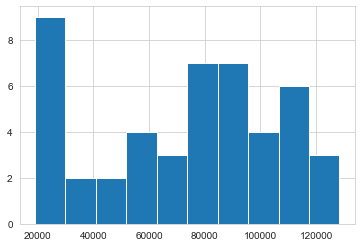

In [13]:
samples_stats["len"].hist()

In [14]:
samples_stats[["isna","missed"]].describe()

,isna,missed
count,47,47
unique,1,1
top,False,False
freq,47,47


In [15]:
pd.Series([v for d in samples_stats.intake_duration for v in d.values() ]).describe()

count                        39
mean     0 days 00:09:51.205128
std      0 days 00:05:05.445160
min             0 days 00:03:01
25%             0 days 00:05:44
50%             0 days 00:09:20
75%             0 days 00:12:52
max             0 days 00:26:05
dtype: object

Ознакомление с даными с датчиков акселерометра и гироскопа

In [16]:
def mean(series):
    return np.mean(series.values, dtype="float64")
def std(series):
    return np.std(series.values, dtype="float64")


stats = [ "min", "max", "mean", "std" ]
sensors = [ "a_x", "a_y", "a_z", "g_x", "g_y", "g_z" ]
sf = {
    "min": np.min,
    "max": np.max,
    "mean": mean,
    "std": std,
}

sensors_stats = pd.DataFrame()
for sensor in sensors:
    for stat in stats:
        sensors_stats[sensor + "_" + stat] = [sf[stat](s[sensor]) for s in samples]
    sensors_stats[sensor + "_-95q"] = [
        -(-s.loc[s[sensor] < 0, sensor]).quantile(q=0.95) for s in samples
    ]
    sensors_stats[sensor + "_+95q"] = [
        s.loc[s[sensor] > 0, sensor].quantile(q=0.95) for s in samples
    ]

In [17]:
sensors_stats.head()

,a_x_min,a_x_max,a_x_mean,a_x_std,a_x_-95q,a_x_+95q,a_y_min,a_y_max,a_y_mean,a_y_std,...,g_y_mean,g_y_std,g_y_-95q,g_y_+95q,g_z_min,g_z_max,g_z_mean,g_z_std,g_z_-95q,g_z_+95q
0,-20.234375,67.06250,0.274528,3.964680,-8.445312,9.906250,-40.90625,23.921875,-5.709525,2.726584,...,0.127554,23.415118,-60.843750,41.165625,-480.5,423.75,-0.171497,31.908473,-48.21875,84.18750
1,-16.781250,36.81250,0.363665,6.826475,-9.593750,12.468750,-62.25000,27.375000,-3.809970,3.875037,...,-0.065261,24.861935,-45.281250,54.684375,-604.0,464.00,-0.076454,34.241586,-68.12500,56.12500
2,-21.562500,33.40625,-1.136170,3.108234,-8.242188,7.767773,-53.59375,33.125000,-6.886198,2.955820,...,0.416827,21.320003,-54.417188,36.625000,-564.5,464.50,-0.220925,26.154395,-33.87500,59.56250
3,-20.750000,77.25000,0.383594,4.134489,-8.023438,9.687500,-44.06250,27.187500,-6.599943,2.866967,...,0.093117,24.436514,-59.218750,44.593750,-638.0,437.50,-0.280893,29.616406,-43.68750,67.56250
4,-19.875000,34.18750,0.245427,5.119745,-8.007812,13.062500,-54.40625,17.390625,-6.491212,2.831158,...,-0.024508,28.084077,-69.812500,51.593750,-575.5,460.50,-0.331544,48.078695,-90.75000,134.33125


In [18]:
sensors_stats.describe().iloc[:,:18]

,a_x_min,a_x_max,a_x_mean,a_x_std,a_x_-95q,a_x_+95q,a_y_min,a_y_max,a_y_mean,a_y_std,a_y_-95q,a_y_+95q,a_z_min,a_z_max,a_z_mean,a_z_std,a_z_-95q,a_z_+95q
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,-19.940160,39.217753,0.131874,4.613125,-8.182655,10.661656,-47.373670,29.056682,-5.379406,3.132814,-9.751621,6.872590,-28.385306,39.469082,4.320124,4.297462,-7.002148,9.460331
std,5.677009,17.147816,0.973514,1.106116,1.497077,1.591675,16.917357,13.152781,1.086459,0.425985,0.316943,1.588740,14.228745,15.279714,1.480684,0.593325,0.939718,0.359720
min,-44.531250,16.250000,-2.808147,2.742479,-9.812500,5.437500,-78.250000,10.289062,-7.320285,2.096257,-10.171875,4.380469,-78.000000,17.328125,1.044851,2.964038,-9.250000,8.046875
25%,-22.796875,28.296875,-0.369468,3.601870,-9.332031,9.500000,-59.171875,20.601562,-6.279328,2.871401,-9.953320,5.536719,-35.859375,26.593750,3.324867,4.003192,-7.561719,9.277344
50%,-18.843750,34.625000,0.274528,4.689659,-8.804688,10.703125,-44.406250,27.078125,-5.508780,3.108252,-9.820312,6.575781,-24.062500,39.625000,4.094226,4.257384,-7.054688,9.539062
75%,-16.640625,41.812500,0.710794,5.465583,-7.058594,11.906250,-34.812500,33.671875,-4.484384,3.414325,-9.664062,8.387695,-19.210938,47.843750,5.090359,4.681127,-6.413379,9.722656
max,-11.304688,78.312500,1.976032,6.826475,-3.461719,13.226562,-16.343750,77.812500,-3.215322,4.105866,-8.609375,9.684375,-9.703125,78.125000,7.821019,5.672247,-5.069922,9.953125


In [19]:
sensors_stats.describe().iloc[:,18:]

,g_x_min,g_x_max,g_x_mean,g_x_std,g_x_-95q,g_x_+95q,g_y_min,g_y_max,g_y_mean,g_y_std,g_y_-95q,g_y_+95q,g_z_min,g_z_max,g_z_mean,g_z_std,g_z_-95q,g_z_+95q
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,-853.889129,1014.823637,-0.091343,43.654665,-82.393085,88.164833,-456.341090,421.175532,0.096652,24.614456,-54.415471,49.484695,-498.523438,451.123670,-0.190976,31.795357,-57.208078,70.812799
std,281.389055,347.976529,0.720409,9.607849,23.321183,23.862387,144.274562,169.708077,0.326232,5.369719,12.243146,14.298979,122.561273,95.033551,0.431570,8.015384,21.956919,22.730670
min,-1503.000000,7.210938,-3.640380,0.057315,-122.000000,6.559668,-1002.500000,1.750000,-0.903423,0.125433,-79.937500,0.700195,-803.500000,42.562500,-2.659541,0.156162,-99.343750,23.796875
25%,-1060.000000,799.750000,-0.463146,40.640790,-98.787500,74.953125,-503.750000,336.500000,-0.054200,21.814250,-62.148438,39.734375,-570.250000,400.625000,-0.333200,26.836099,-74.890625,59.071875
50%,-811.500000,963.500000,-0.215036,43.484568,-85.250000,89.000000,-453.000000,400.000000,0.093117,24.861935,-54.331250,50.625000,-513.000000,464.000000,-0.184197,31.850939,-56.000000,66.437500
75%,-668.000000,1200.000000,0.490040,48.037557,-69.565625,99.781250,-376.375000,453.625000,0.283425,27.863029,-49.359375,60.301562,-430.000000,506.875000,0.050096,35.863356,-40.743750,79.570312
max,-10.289062,2294.000000,0.834554,65.007830,-3.640625,145.125000,-35.906250,1161.000000,0.723267,33.964355,-18.687500,72.312500,-5.601562,626.000000,0.448856,48.078695,-2.660156,134.331250


Визуализация:

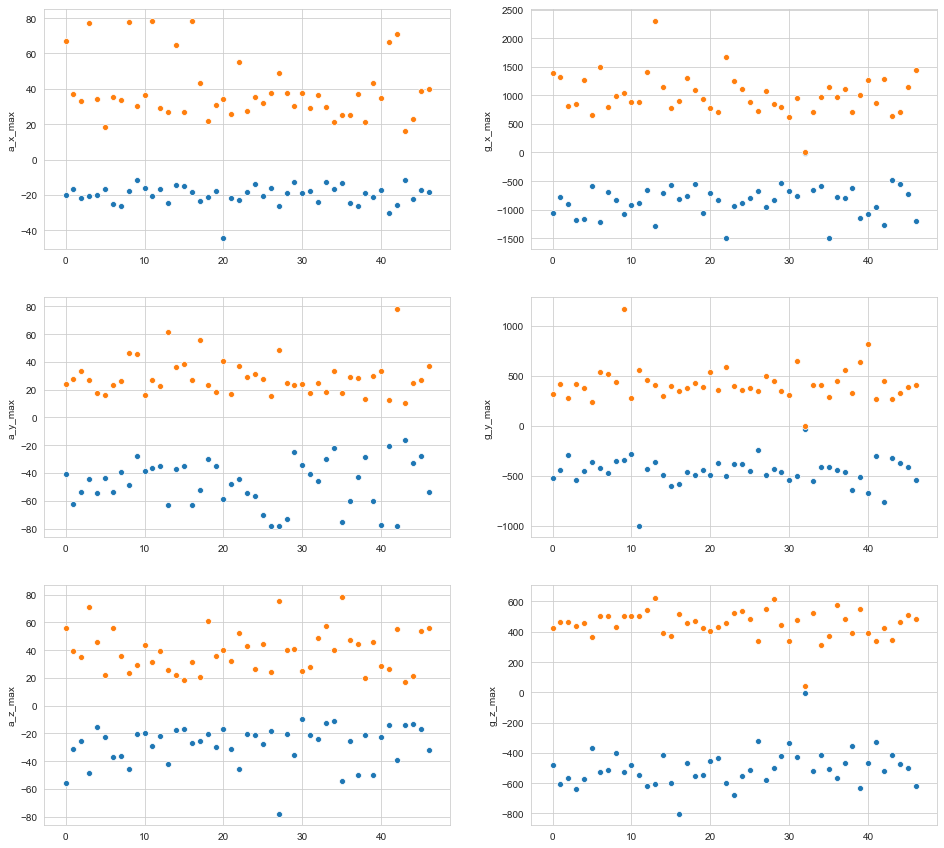

In [20]:
i = 1
with plt.rc_context({"figure.figsize": [16, 15]}):
    fig = plt.figure()
    for sensor in sensors:
        ax = fig.add_subplot(3, 2, i % 6 + i // 6)
        for stat in ["min", "max"]:
            sns.scatterplot(
                data=sensors_stats, y=sensor + "_" + stat, x=sensors_stats.index, ax=ax
            )
        i += 2

На графике отображены минимумы и максимумы показаний датчиков для каждой серии измерений (ось $x$)

Значения для $a_x$, $a_y$ и $a_z$ явных выбросов не содержат.

Для гироскопа видно аномальное значение $\approx0$ у серии номер 32 или 33. Так же видны необычно большое значение максимума $g_x$ для одной серии ( номером в районе 12 или 13) и $g_y$ также для одной серии с номером 8 или 9. 

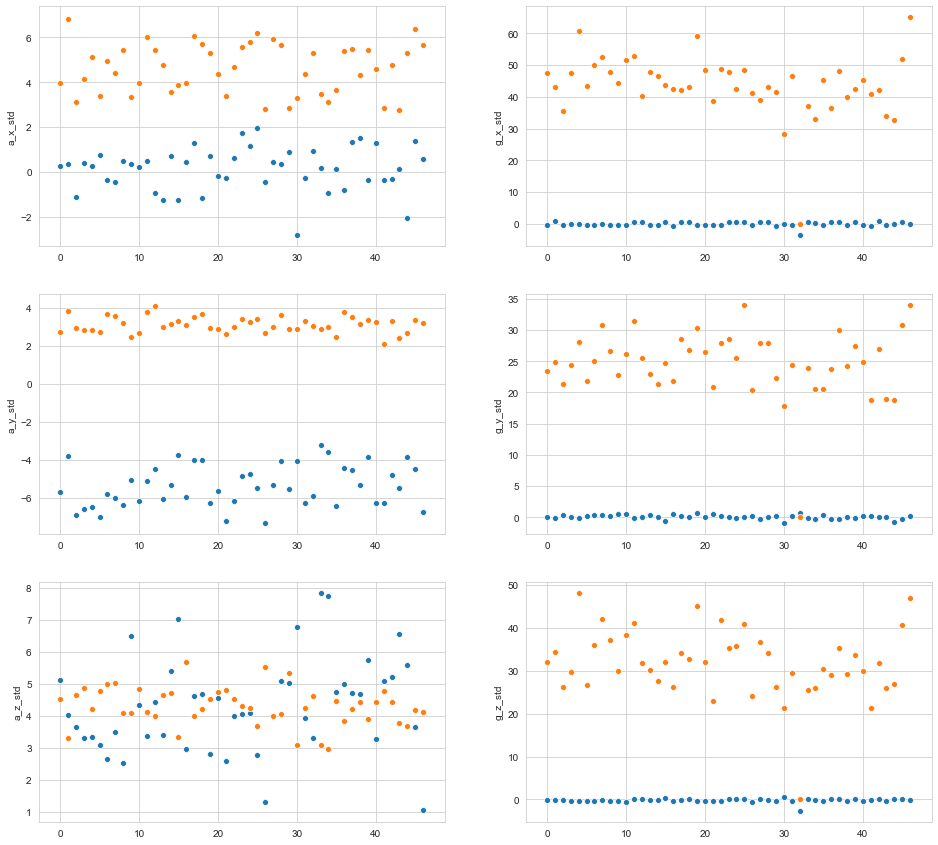

In [21]:
i = 1
with plt.rc_context({"figure.figsize": [16, 15]}):
    fig = plt.figure()
    for sensor in sensors:
        ax = fig.add_subplot(3, 2, i % 6 + i // 6)
        for stat in ["mean", "std"]:
            sns.scatterplot(
                data=sensors_stats, y=sensor + "_" + stat, x=sensors_stats.index, ax=ax
            )
        i += 2

На графиках отображены среднее и среднеквадратичное отклонение показаний датчиков для каждой серии измерений (ось $x$)

Явных выбросов на графиках не прослеживается, за исключением показаний сенсоров гироскопа в серии с номером 32 или 33

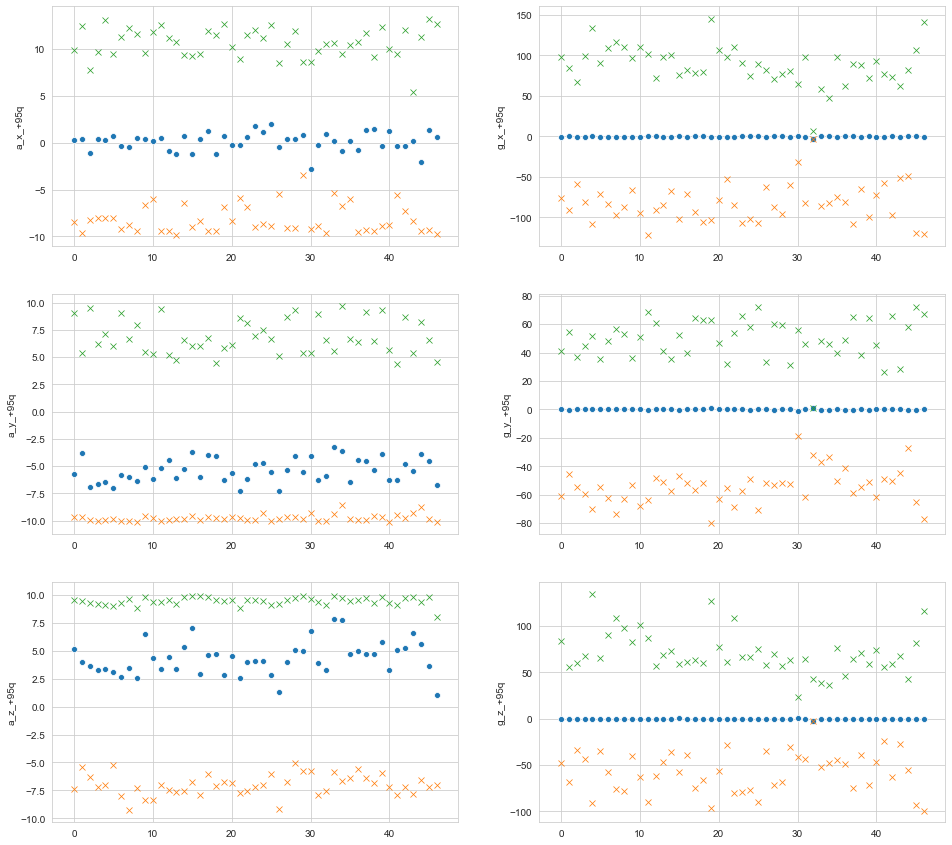

In [22]:
i = 1
with plt.rc_context({"figure.figsize": [16, 15]}):
    fig = plt.figure()
    for sensor in sensors:
        ax = fig.add_subplot(3, 2, i % 6 + i // 6)
        sns.scatterplot(
            data=sensors_stats, y=sensor + "_mean", x=sensors_stats.index, ax=ax
        )
        sns.scatterplot(
            data=sensors_stats,
            y=sensor + "_-95q",
            x=sensors_stats.index,
            ax=ax,
            marker="x",
        )
        sns.scatterplot(
            data=sensors_stats,
            y=sensor + "_+95q",
            x=sensors_stats.index,
            ax=ax,
            marker="x",
        )
        i += 2

На графиках отображены квантили уровня .95 показаний датчиков для каждой серии измерений (ось $x$)

Явных выбросов на графиках не прослеживается, за исключением показаний сенсоров гироскопа в серии с номером 32 или 33

Найдём и проверим показания датчиков гироскопа в выделяющейся серии:

In [23]:
gminmax = (
    sensors_stats.g_x_max.idxmin(),
    sensors_stats.g_y_max.idxmin(),
    sensors_stats.g_z_max.idxmin(),
)
gmanmin = (
    sensors_stats.g_x_min.idxmax(),
    sensors_stats.g_y_min.idxmax(),
    sensors_stats.g_z_min.idxmax(),
)
print(f"giro min max series: {gminmax}\ngiro max min series: {gmanmin}")

giro min max series: (32, 32, 32)
giro max min series: (32, 32, 32)


In [24]:
samples[32][["g_x","g_y","g_z"]]

,g_x,g_y,g_z
2019-10-08 10:48:51.000000,-10.289062,-35.906250,42.562500
2019-10-08 10:48:51.099809,0.770020,-0.140015,-0.350098
2019-10-08 10:48:51.199603,-0.140015,0.419922,-0.560059
2019-10-08 10:48:51.299403,0.280029,0.560059,-0.209961
2019-10-08 10:48:51.399185,-1.259766,1.679688,-0.560059
...,...,...,...
2019-10-08 13:11:15.729995,-3.640625,0.700195,-2.660156
2019-10-08 13:11:15.829790,-3.640625,0.700195,-2.660156
2019-10-08 13:11:15.929580,-3.640625,0.700195,-2.660156
2019-10-08 13:11:16.029377,-3.640625,0.700195,-2.660156


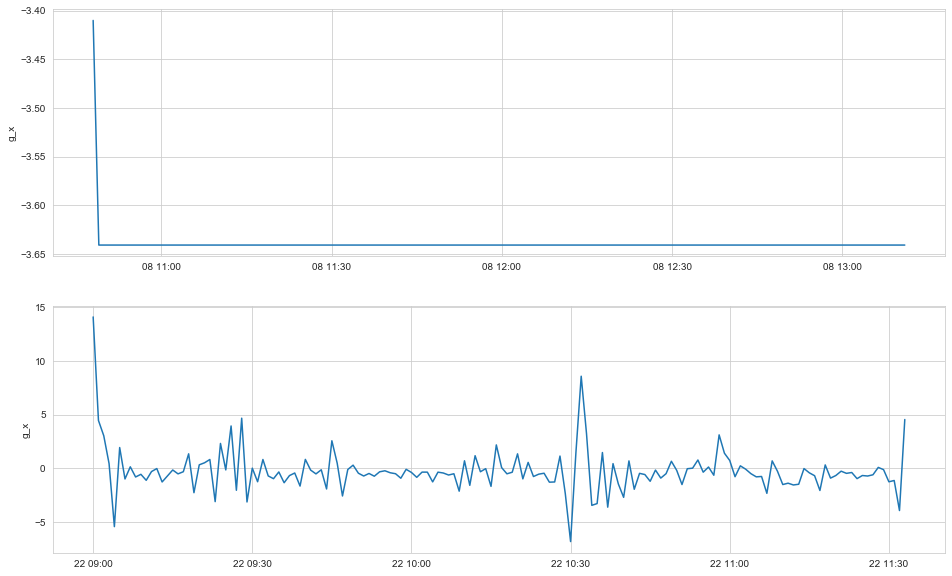

In [25]:
with plt.rc_context({'figure.figsize': [16,10]}):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    s = samples[32].resample("60S").mean()
    sns.lineplot(data=s, y='g_x', x=s.index, ax=ax)
    ax = fig.add_subplot(212)
    s = samples[0].resample("60S").mean()
    sns.lineplot(data=s, y='g_x', x=s.index, ax=ax)

Вероятно, в 32 серии гироскоп неисправен. В связи с этим удалим эту серию.

In [26]:
del samples[32]
samples_stats.drop(32, inplace=True)
sensors_stats.drop(32, inplace=True)

### Итог

Данные представлены в форме 47 отдельных серий, каждая серия содержит отсчёты со следующей информацией:
- время отсчёта
- измерения сенсоров акселерометра (три оси)
- гиросокпа (три оси)
- метку


Продолжительность серий в среднем 2 часа ($\approx70000$ отсчётов), есть несколько коротких серий длительностью около 30 минут.


Пропущенных (na) значений в данных нет, также все серии без пропущенных отсчётов.


Метки представляют два класса - 0 и 1. Серии содержат от 0 до 2 приёмов. В среднем, приём пищи длится чуть меньше 10 минут, максимальный приём длился 21 минуту, минимальный - 3 минуты.


Анализ данных сенсоров показал средние значения и разброс показаний сенсоров, и выявил одну серию с некорректными данными.

## Анализ задачи

### Исходные предположения

Предполагаем, что новые данные для классификации будут поступать, как и тренировочный набор, в форме непрерывных серий  отсчётов. Частота отсчётов полагается фиксированной и равной 10 Гц.


Явно в вводных данных не указано какое устройство представляет данные от акселерометра и гироскопа, но на основе приведённых для изучения ссылклок, далее буду исходить из предположения что это smartwatch.


### Фреймворк решения


Модель приёма пищи,  следуя [Thomaz](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5839104/pdf/nihms728790.pdf), представим в виде кластера жестов, классифицированных как относящиеся к потреблению еды. 


Каждую серию отсчётов поэтому разобъём на фреймы фиксированной длины, и обучим ML-модель классифицировать фрейм как жест относящийся к приёму пищи ($C_1$), или нет ($C_0$)


Далее, на основе работы ML-модели промаркируем соответствующие фреймам из $C_1$ отсчёты, и найдём периоды приёма пищи.


### Определения

Для консистентности положим следующие термины:


* серия    (series)   - входной массив отсчётов
* отсчёт   (sample)   - одиничное измерение датчика
* фрэйм    (frame)    - последовательная серия отсчётов фиксированной длины
* признаки (features) - классифицируемый набор признаков фрейма

### План решения

Решение будет иметь следующую структуру:

1. Предобработка данных (preprocessing): этап выработки подходящих способов, подбора параметров и применения методов предварительной обработки поступающих данных.
2. Разбивка данных на фреймы: определение способа разбивки на фреймы, выбор параметров.
3. Извеление признаков из фреймов: определение подходящих признаков, извлечение  и т.п.
4. ML-модель: подбор и обучение ML-модели классификации фреймов.
5. Классификация серии: маркировка отсчётов, подбор параметров, получение кластера положительных отсчётов, получение итогого временного интервала.
6. Итоговый прогон на тестовых данных, оценка качества классификации.


_В описаниях этапов под "TODO:" помечаются идеи для дальнейшей углублённой разработки решения_


***

Предварительно промаркируем серии и разделим их на три части: обучабщий набор для классификатора фреймов, обучающий набор для подбора параметров классификации интервалов и тестовый набор. Размер наборов постараемся подобрать таким образом, чтобы $\approx33\%$ отсчётов от общего числа и $\approx33\%$ приёмов пищи попали в тестовый набор.

In [27]:
ratio = 1/3

for i, s in enumerate(samples):
    s["sid"] = i

sfort = np.round(samples_stats["len"].sum() * ratio).astype(int)
ifort = np.round(samples_stats["intake_count"].sum() * ratio).astype(int)

print(f"Approx. samples per subset: {sfort}")
print(f"Approx. intakes per subset: {ifort}")

separator = np.round(len(samples) / 3).astype('int')
idx = np.random.permutation(len(samples))

serieses_guestures = [samples[i].copy() for i in idx[0:separator]]
serieses_intakes   = [samples[i].copy() for i in idx[separator:separator*2]]
serieses_test      = [samples[i].copy() for i in idx[separator*2:]]

sforg = sum([len(s) for s in serieses_guestures])
iforg = sum([len(intake_duration(s[s.target == 1])) for s in serieses_guestures])
sfori = sum([len(s) for s in serieses_intakes])
ifori = sum([len(intake_duration(s[s.target == 1])) for s in serieses_intakes])
sfort = sum([len(s) for s in serieses_test])
ifort = sum([len(intake_duration(s[s.target == 1])) for s in serieses_test])


print(f"\nResult samples for guesture classification train: {sforg}")
print(f"Result intakes for guesture classification train: {iforg}")
print(f"\nResult samples for intake classification train: {sfori}")
print(f"Result intakes for intake classification train: {ifori}")
print(f"\nResult samples for test: {sfort}")
print(f"Result intakes for test: {ifort}")

Approx. samples per subset: 1112545
Approx. intakes per subset: 13

Result samples for guesture classification train: 1179010
Result intakes for guesture classification train: 13

Result samples for intake classification train: 1089361
Result intakes for intake classification train: 12

Result samples for test: 1069265
Result intakes for test: 13


## Preprocessing


* данные сенсоров имеют тип 'float16', поэтому преобразовываем их в float64.
* т.к. данные представляют собой временной ряд, нивелируем шум скользящим экспоненциальным средним. Экспоненциальный вес выберем через величину окна усреднения в 1 секунду (10 отсчётов).
* TODO: проверить другие значения $\alpha$.
* TODO: проверить гипотезу о позитивном влиянии нормализации на результат.

In [28]:
ewm_alpha_span = 10

In [29]:
def preprocess(serieses):
    ret = [s.copy() for s in serieses]
    for s in ret:
        s[sensors] = s[sensors].astype("float64")
        s[sensors] = s[sensors].ewm(span=ewm_alpha_span).mean()
    return ret

## Features extraction

### Разбиение на фреймы

* Серии разбиваем на фреймы шириной 6 секунд (60 отсчётов), с шагом в половину окна (3 секунды, 30 отсчётов).
 * TODO: проверить другие значения ширины фрейма и шага
 * TODO: проверить возможность вычленения жестов непосредсвтенно из временного ряда
* Каждому фрейму генерируется свой ID.
* "Хвост" серии, т.е. последние $n$ отсчётов, не попадающие в целый фрейм - отбрасываем.

Фреймы помещаются в один общий датафрейм для последущего извлечения признаков.

In [30]:
frame_size = 6 * resolution   # 6 sec
frame_step = frame_size // 2  # половина окна

In [31]:
def frames_extract(serieses):
    frames = []
    for i, s in enumerate(serieses):
        temp = [
            s[start : start + frame_size]
            for start in range(0, len(s) - frame_size + 1, frame_step)
        ]
        frames.append(pd.concat(temp))
    frames = pd.concat(frames)
    index = [[i] * frame_size for i in range(len(frames) // frame_size)]
    frames["id"] = [i for frame_idx in index for i in frame_idx]
    frames["datetime"] = frames.index
    frames.index = range(len(frames))
    return frames

### Извлечение признаков


Для начала воспользуемся базовым набором свойств: медиа, матожидание, максимум, минимум, квантили ур. .95, и др.
Далее признаки можно будет тюнить и выбирать релевантные признаки более тщательно


Целевую переменную сохраним в отдельном датафрейме. При этом:
* Метка времени на фрейме устанавливается равной первому отчёту фрейма.
* Целевая переменная для фрейма выбирается равной 1 при условии что $>75\%$ отсчётов в фрейме имеют целевой признак равный 1
 * TODO: проверить влияние метода установки целевой переменной для фрейма на точность классификации


In [32]:
from tsfresh import extract_features

In [33]:
settings = {}
settings["minimum"] = None
settings["maximum"] = None
settings["median"] = None
settings["mean"] = None
settings["variance"] = None
settings["standard_deviation"] = None
settings["kurtosis"] = None
settings["skewness"] = None
settings["agg_autocorrelation"] = [
    {"f_agg": "mean", "maxlag": frame_size},
    {"f_agg": "median", "maxlag": frame_size},
    {"f_agg": "var", "maxlag": frame_size},
]
settings["quantile"] = [{"q": 0.95}]


efp = functools.partial(
    extract_features,
    n_jobs=9,
    column_id="id",
    column_sort="datetime",
    disable_progressbar=True,
    default_fc_parameters=settings,
)

In [34]:
def features_extract(frames):
    step = 5000
    frtmp = frames[["id", "datetime"] + sensors]
    ids = frtmp["id"].unique()

    features = [
        efp(frtmp[frtmp["id"].isin(ids[start : start + step])])
        for start in range(0, len(ids), step)
    ]
    features = pd.concat(features)
    targets = frames[["id", "target"]].groupby("id").sum() // (3 * frame_size // 4)

    return features, targets

## Классификатор жестов


Обучаем модель. Пробуем логистическую регрессию, SVM и GradientBoost.

Так как GradientBoost показал лучшие результаты, то остановися на нём. Дополнительно подберём методом кроссвалидации.

TODO: провреить другие алгоритмы (нейросети)

In [35]:
import sklearn.preprocessing   as skpp
import sklearn.model_selection as skms
import sklearn.metrics         as skmt

import sklearn.linear_model    as sklm
import sklearn.svm             as sksv
import sklearn.ensemble        as sken

import sklearn.pipeline        as skpl

from sklearn.experimental import enable_hist_gradient_boosting

In [36]:
def get_scores(y_trn, p_trn, y_tst, p_tst):
    scores = [
        [
            skmt.accuracy_score(y, p),
            skmt.precision_score(y, p),
            skmt.recall_score(y, p),
            skmt.f1_score(y, p),
        ]
        for y, p in zip([y_trn, y_tst], [p_trn, p_tst])
    ]
    return pd.DataFrame(
        scores,
        index=[["train", "test"]],
        columns=["accuracy", "precision", "recall", "f1"],
    )

In [37]:
serieses = preprocess(serieses_guestures)
frames = frames_extract(serieses)
features, targets = features_extract( frames )

In [38]:
x_trn, x_tst, y_trn, y_tst = skms.train_test_split(features, targets, test_size=0.33)

In [39]:
scaler = skpp.StandardScaler().fit(x_trn)
x_trn = scaler.transform(x_trn)
x_tst = scaler.transform(x_tst)
y_trn = y_trn.target.values
y_tst = y_tst.target.values

In [40]:
estimators = [
    sklm.LogisticRegression(solver="sag", max_iter=10000, n_jobs=-1),
    sksv.SVC(),
    sken.HistGradientBoostingClassifier(scoring="f1"),
]

In [41]:
scores = []
for est in estimators:
    est.fit(x_trn, y_trn)
    p_trn = est.predict(x_trn)
    p_tst = est.predict(x_tst)
    scores.append(get_scores(y_trn, p_trn, y_tst, p_tst))
scores = pd.concat(scores, keys=estimators)

scores

accuracy  precision  \
LogisticRegression(C=1.0, class_weight=None, du... train  0.952044   0.751623   
                                                   test   0.950933   0.720779   
SVC(C=1.0, break_ties=False, cache_size=200, cl... train  0.961278   0.888889   
                                                   test   0.957105   0.827273   
HistGradientBoostingClassifier(l2_regularizatio... train  0.992856   0.973324   
                                                   test   0.965669   0.793537   

                                                            recall        f1  
LogisticRegression(C=1.0, class_weight=None, du... train  0.294529  0.423218  
                                                   test   0.287565  0.411111  
SVC(C=1.0, break_ties=False, cache_size=200, cl... train  0.402036  0.553657  
                                                   test   0.353627  0.495463  
HistGradientBoostingClassifier(l2_regularizatio... train  0.905216  0.938036  
                                                   test   0.572539  0.665162

Низкие значения Recall ожидаемы, т.к. у нас классифицирован интервал приёма пищи целиком и поэтому содержит много посторонних жестов. Статистики таких жестов заставляют алгоритм относить их к классу $C_0$, а целевая переменная - к классу $C_1$, что увеличивает частоту FN, и, следовательно, снижает Recall.

Чувствительность (precision) выше у SVC, а полнота (recall) - у GradienBoost. Но SVC даёт даёт небольшой прирост чувствительности по сравнению с приростом полноты для GradientBoost (это видно по метрике f1), поэтому остановимся на модели GradientBoost.

Подберём параметры для GradientBoost методом кроссвалидации. Параметры перебирать будем медом grid search.

TODO: более аккуратный способ определения гиперпараметров

In [42]:
parameters = {'max_depth':[5,10,15],
              'max_iter': [1000,1500,2000],
              }
gdboost = sken.HistGradientBoostingClassifier(scoring='f1')
gs = skms.GridSearchCV( gdboost, parameters ).fit(x_trn, y_trn)
                               
p_trn = gs.predict(x_trn)
p_tst = gs.predict(x_tst)

print("Gradient boost at the best:")
get_scores(y_trn, p_trn, y_tst, p_tst)

Gradient boost at the best:


,accuracy,precision,recall,f1
train,1.000000,1.000000,1.000000,1.000000
test,0.968755,0.827094,0.601036,0.696174


In [43]:
params = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").iloc[0].params

In [44]:
params

{'max_depth': 15, 'max_iter': 1000}

Готовим итоговый пайплайн:

In [45]:
gdboost = sken.HistGradientBoostingClassifier(
    scoring="f1", max_depth=params["max_depth"], max_iter=params["max_iter"]
)
guesture_classificator = skpl.Pipeline([("scaler", scaler), ("estimator", gdboost)])

x_trn, x_tst, y_trn, y_tst = skms.train_test_split(features, targets, test_size=0.33)
guesture_classificator.fit(x_trn, y_trn.target)

print("Resulting classificator check:")
p_trn = guesture_classificator.predict(x_trn)
p_tst = guesture_classificator.predict(x_tst)
get_scores(y_trn, p_trn, y_tst, p_tst)

Resulting classificator check:


,accuracy,precision,recall,f1
train,1.000000,1.000000,1.000000,1.000000
test,0.970221,0.843327,0.588394,0.693164


## Классификация приёмов пищи


Для классификации интервалов приёма пищи пометим в серии отсчёты, которые наш классификатор отнёс к жестам приёма пищи.
Приём пищи длится несколько минут, поэтому ожидается, что количество предсказанных жестов при приёме пищи будет велико, в другие интеравлы - наоборот мало.

Таким образом будем классифицировать как интервал приёма пищи интервалы с высокой частотой классифицированных жестов.

In [46]:
def predict_guestures( features ):
    return pd.Series(guesture_classificator.predict(features), index=features.index)

TODO: выбор меток для отсчётов, общих для фреймов из разных классов

In [47]:
def label_serieses( serieses, frames_table, prediction ):
    frames = frames_table.copy()
    labels = [[prediction[i]] * frame_size for i in range(len(prediction))]
    frames["labels"] = [i for frame_label in labels for i in frame_label]

    ret = []
    for s in serieses:
        temp = frames[ frames.sid == s.sid[0] ]
        labels  = temp[["datetime","labels"]].groupby("datetime").max()
        ret.append( s.join(labels).fillna(0) )

    return ret

In [48]:
def predict_intakes( serieses, window, level, center ):
    ret = [ ]
    for s in serieses:
        temp = s.copy()
        s["density"] = s[["labels"]].rolling(window=window, center=center, min_periods=1).sum()/window
        s["intake_predicted"] = 0
        s.loc[s["density"] > level, "intake_predicted"] = 1
        ret.append(s)
    return ret

In [49]:
def get_scores_intake(serieses):
    scores = []
    for s in serieses:
        if (s.target!=0).any() and (s.intake_predicted!=0).any():
            scores.append([
                skmt.accuracy_score(s.target,s.intake_predicted),
                skmt.precision_score(s.target,s.intake_predicted),
                skmt.recall_score(s.target,s.intake_predicted),
                skmt.f1_score(s.target,s.intake_predicted),
                skmt.jaccard_score(s.target,s.intake_predicted)])
        else:
            scores.append([skmt.accuracy_score(s.target,s.intake_predicted),None, None, None, None])
    return pd.DataFrame( scores, columns=["accuracy", "precision", "recall", "f1", "jaccard"])


Готовим тренировочные данные:

In [50]:
serieses = preprocess(serieses_intakes)
frames = frames_extract(serieses)
features, targets = features_extract(frames)

Предсказываем жесты и размечаем серии:

In [51]:
prediction = predict_guestures(features)

print("Guestures predictions:")
print(f"\tAccuracy check:\t {skmt.accuracy_score(targets.target, prediction):.4f}")
print(f"\tPrecision check: {skmt.precision_score(targets.target, prediction):.4f}")
print(f"\tRecall check:\t {skmt.recall_score(targets.target, prediction):.4f}")
print(f"\tF1 check:\t {skmt.f1_score(targets.target, prediction):.4f}")

labeled_serieses = label_serieses(serieses, frames, prediction)

Guestures predictions:
	Accuracy check:	 0.9399
	Precision check: 0.7797
	Recall check:	 0.3033
	F1 check:	 0.4368


Проверим классификацию:

In [52]:
labeled_serieses = predict_intakes(labeled_serieses,window=60,level=.5,center=True)
get_scores_intake( labeled_serieses )

,accuracy,precision,recall,f1,jaccard
0,0.945154,0.820153,0.597913,0.691618,0.528606
1,0.852053,0.621910,0.116888,0.196790,0.109133
2,0.982284,0.867133,0.871009,0.869067,0.768451
3,0.973097,0.896170,0.785040,0.836932,0.719590
4,0.950438,0.539462,0.231399,0.323874,0.193228
5,1.000000,NaN,NaN,NaN,NaN
6,0.966647,0.849889,0.589697,0.696279,0.534071
7,1.000000,NaN,NaN,NaN,NaN
8,0.920423,0.597091,0.324874,0.420796,0.266461
9,0.994551,NaN,NaN,NaN,NaN


Поищем оптимальные параметры:

In [53]:
win_sizes = np.array([1,60,120,180,240,300]) * resolution
levels = [.1,.25,.5]

scores_cv = []
for w in win_sizes:
    for l in levels:
        for c in [True,False]:
            labeled_serieses = predict_intakes(labeled_serieses,window=w,level=l,center=c)
            score_local = get_scores_intake( labeled_serieses )
            scores_cv.append( [ w, l, c, score_local.f1.mean(), score_local.f1.std() ])
        
scores_cv = pd.DataFrame(scores_cv, columns=["window","level","center","f1_mean","f1_std"])

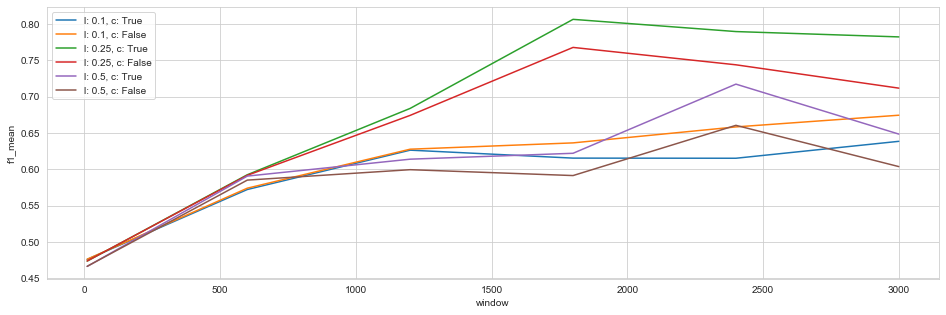

In [54]:
with plt.rc_context({"figure.figsize": [16, 5]}):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for l in levels:
        for c in [True,False]:
            sr = scores_cv[ (scores_cv.level==l) & (scores_cv.center==c) ]
            sns.lineplot(x=sr.window, y=sr.f1_mean, ax=ax, label="l: "+str(l)+", с: "+str(c))

In [55]:
scores_cv.iloc[scores_cv.f1_mean.idxmax()]

window         1800
level          0.25
center         True
f1_mean     0.80666
f1_std     0.232799
Name: 20, dtype: object

Остановимся на окне 3 минуты (180 секунд, 1800 отсчётов).

In [56]:
window, level, center = 180 * resolution, .25, True

In [57]:
labeled_serieses = predict_intakes(labeled_serieses,window=window,level=level,center=center)
scores = get_scores_intake( labeled_serieses )

In [58]:
scores

,accuracy,precision,recall,f1,jaccard
0,0.998276,0.990535,0.992728,0.991630,0.983399
1,0.877606,0.966300,0.218234,0.356055,0.216586
2,0.993543,0.912694,1.000000,0.954354,0.912694
3,0.993870,0.934836,1.000000,0.966320,0.934836
4,0.948701,NaN,NaN,NaN,NaN
5,1.000000,NaN,NaN,NaN,NaN
6,0.992774,0.899722,1.000000,0.947214,0.899722
7,1.000000,NaN,NaN,NaN,NaN
8,0.965515,0.989556,0.618970,0.761574,0.614953
9,1.000000,NaN,NaN,NaN,NaN


## Итоговая проверка классификатора

In [59]:
serieses = preprocess(serieses_test)
frames = frames_extract(serieses)
features, targets = features_extract(frames)

In [60]:
prediction = predict_guestures(features)

print("Guestures predictions:")
print(f"\tAccuracy check:\t {skmt.accuracy_score(targets.target, prediction):.4f}")
print(f"\tPrecision check: {skmt.precision_score(targets.target, prediction):.4f}")
print(f"\tRecall check:\t {skmt.recall_score(targets.target, prediction):.4f}")
print(f"\tF1 check:\t {skmt.f1_score(targets.target, prediction):.4f}")

labeled_serieses = label_serieses(serieses, frames, prediction)
labeled_serieses = predict_intakes(labeled_serieses,window=window,level=level,center=center)
scores = get_scores_intake( labeled_serieses )

Guestures predictions:
	Accuracy check:	 0.9622
	Precision check: 0.8268
	Recall check:	 0.5541
	F1 check:	 0.6635


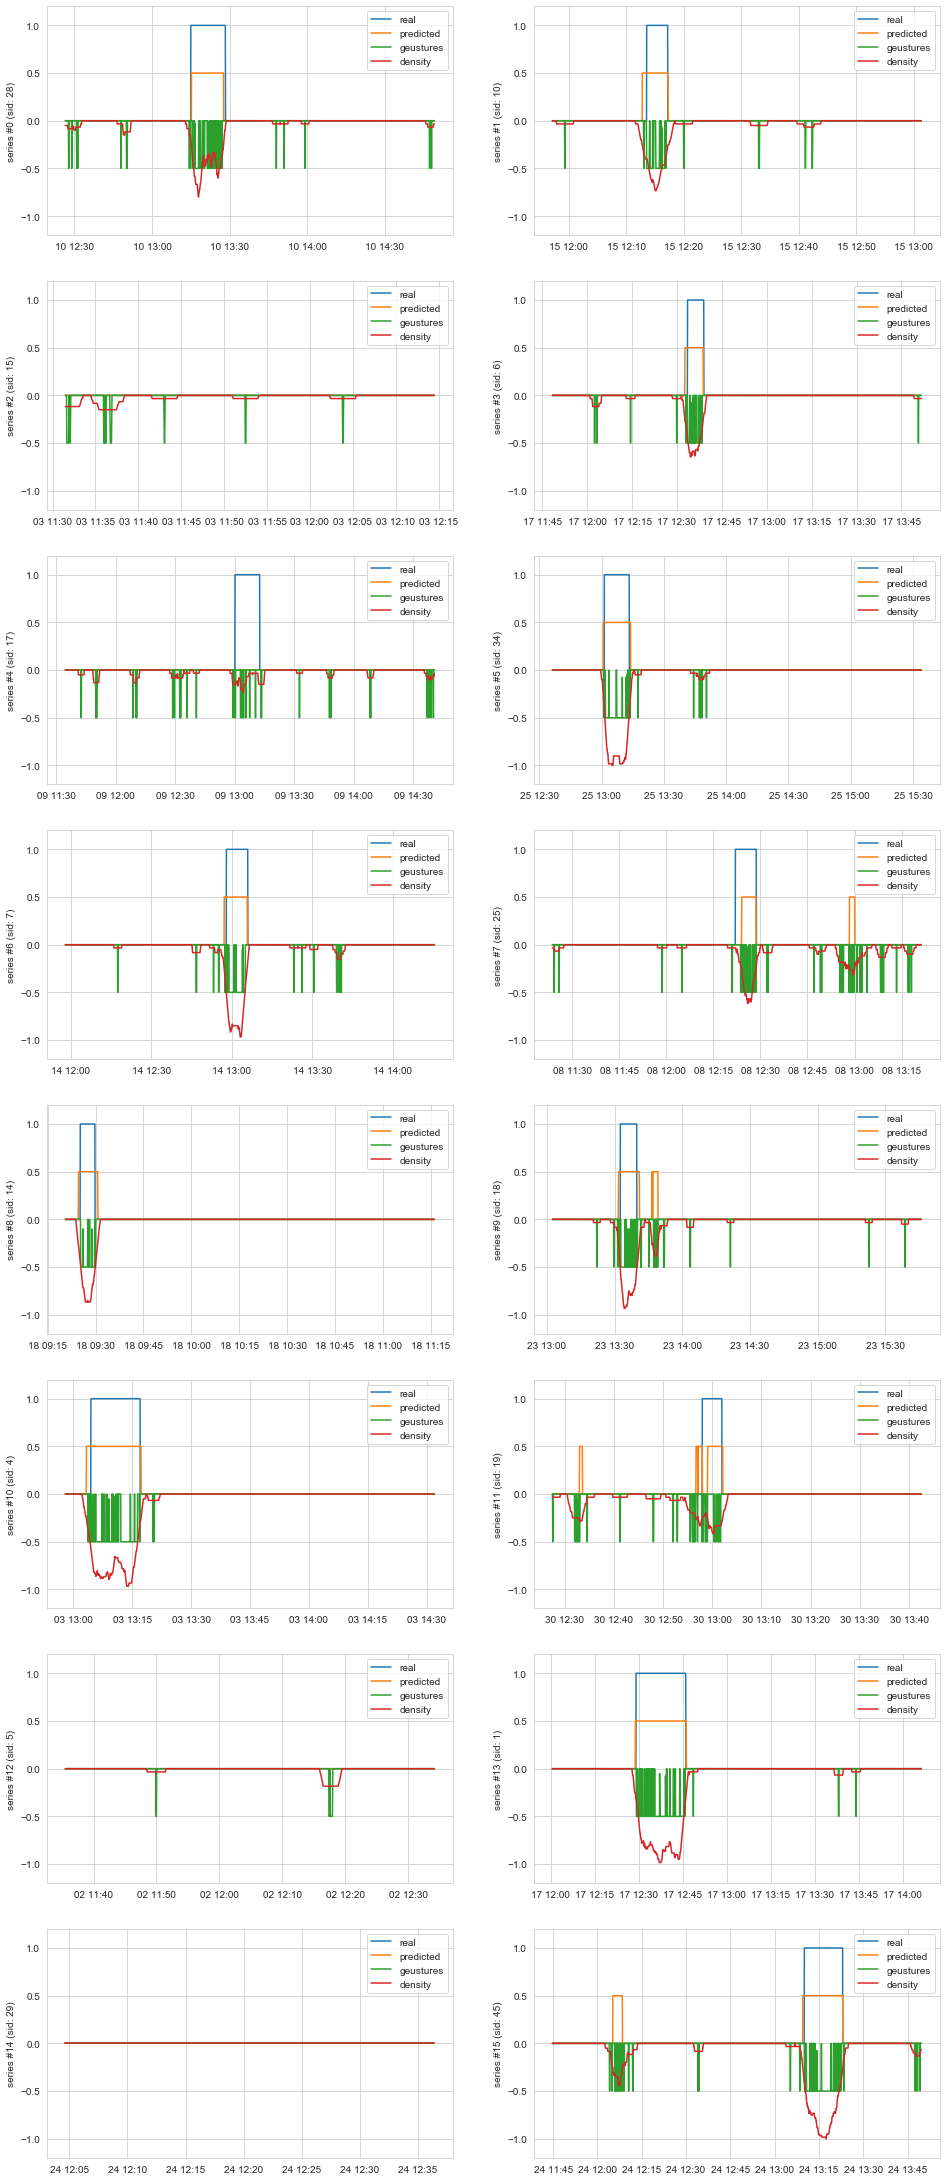

In [61]:
with plt.rc_context({"figure.figsize": [16, int(np.ceil(len(labeled_serieses)))*5]}):
    fig = plt.figure()
    for i,s in enumerate(labeled_serieses):
        sr = s.resample("2S").mean()
        ax = fig.add_subplot(int(np.ceil(len(labeled_serieses))),2,i+1)
        ax.set(ylim=(-1.2, 1.2))
        sns.lineplot(x=sr.index, y=sr.target,               ax=ax, label="real")
        sns.lineplot(x=sr.index, y=sr.intake_predicted *.5, ax=ax, label="predicted")
        sns.lineplot(x=sr.index, y=-sr.labels*.5,           ax=ax, label="geustures")
        sns.lineplot(x=sr.index, y=-sr.density,             ax=ax, label="density")
        ax.set_ylabel("series #"+str(i)+" (sid: "+str(s.sid[0])+")")

In [62]:
scores

,accuracy,precision,recall,f1,jaccard
0,0.993204,1.000000,0.927711,0.962500,0.927711
1,0.987125,0.816228,1.000000,0.898817,0.816228
2,1.000000,NaN,NaN,NaN,NaN
3,0.991290,0.857685,0.963459,0.907500,0.830664
4,0.932863,NaN,NaN,NaN,NaN
5,0.993411,0.911226,1.000000,0.953551,0.911226
6,0.992810,0.908122,0.975229,0.940480,0.887647
7,0.967688,0.730281,0.686148,0.707527,0.547421
8,0.987378,0.760590,1.000000,0.864017,0.760590
9,0.973115,0.624056,1.000000,0.768515,0.624056


In [63]:
print(f"Test serieses set classification F1 score: {scores.f1.mean():.2f} ± {scores.f1.std():.2f}")

Test serieses set classification F1 score: 0.87 ± 0.11
